**Plan of the work:**

1)take model

2)take default CIFAR100 dataset

3)construct  3 subdatasets:


*   10 hard classes only
*   10 easy classes only
*   10 random classes


4)for fixed n_epochs measure acc after adv training on each dataset

6)compare results.





In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
set_seed(42)

#Model

In [3]:
class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18(num_classes=10):
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes)

In [4]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

def get_loaders(data_dir='cifar-100', batch_size=32, augments=[True, False], shuffles=[True, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PreActResNet18(num_classes=10).to(device)

print(device)

cuda


#Adv training on default dataset

In [6]:
weight_decay = 5e-4
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.3
fgsm_step = 1
delta_init = 'random'
model.train()
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

In [7]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

In [8]:
NUM_CLASSES = 10

def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=None):
    max_loss = torch.zeros(y.shape[0]).to(device)
    max_delta = torch.zeros_like(X).to(device)
    scaler = torch.cuda.amp.GradScaler()
    for _ in range(restarts):
        delta = torch.zeros_like(X).to(device)
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True
        for _ in range(attack_iters):
            with torch.cuda.amp.autocast():
                output = model(X + delta)
                index = torch.where(output.max(1)[1] == y)[0]
                if len(index) == 0:
                    break
                loss = F.cross_entropy(output, y)
            scaler.scale(loss).backward()
            grad = delta.grad.detach()
            d = delta[index, :, :, :]
            g = grad[index, :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index, :, :, :], upper_limit - X[index, :, :, :])
            delta.data[index, :, :, :] = d
            delta.grad.zero_()

        all_loss = F.cross_entropy(model(X + delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta


def evaluate_pgd(test_loader, model, attack_iters, restarts, epsilon, alpha, lower_limit, upper_limit, args=None):

    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}

    pgd_loss, pgd_acc = 0, 0
    n = 0
    model.eval()
    for i, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        pgd_delta = attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=args)
        with torch.no_grad():
            output = model(X + pgd_delta)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            pgd_loss += loss.item() * y.size(0)
            pgd_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
        acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return pgd_loss/n, pgd_acc/n,acc_per_class


def evaluate_standard(test_loader, model, args=None):
    
    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}
    
    test_loss, test_acc = 0, 0
    n = 0
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            test_loss += loss.item() * y.size(0)
            test_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
    acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return test_loss/n, test_acc/n,acc_per_class


In [9]:
epochs = 30

In [10]:
hard_classes = [13,35,55,72,96,10,44,65,74,4]
easy_classes = [8,9,20,87,94,21,41,39,53,68]
random_classes = list(np.unique(np.random.randint(0,100,20)))[:10]

In [11]:
def get_label(c):
  labels = []
  if c in hard_classes:
    labels.append('hard')
  elif c in easy_classes:
    labels.append('easy')
  elif c in random_classes:
    labels.append('random')
  else:
    labels.append('no interes')
  return labels

In [12]:
print(random_classes)

[1, 2, 14, 20, 21, 23, 29, 37, 51, 52]


In [13]:
keys = ['hard','easy','random']

X_train = dict()
X_test = dict()

y_train = dict()
y_test = dict()

dicts = [X_train,X_test,y_train,y_test]
for key in keys:
  for d in dicts:
    d[key] = []

In [14]:
classes = dict()
classes['easy'] = easy_classes
classes['hard'] = hard_classes
classes['random'] = random_classes

labels = ['hard','easy','random']

labels_match = dict()
for label in labels:
  labels_match[label] = {class_label : idx for idx,class_label in enumerate(classes[label])}
print(labels_match)

def targets_rewrite(targets,mapping):
  targets = [mapping[t.item()] for t in targets]
  return torch.LongTensor(targets)

print(targets_rewrite(torch.Tensor([8]),labels_match['easy']))

{'hard': {13: 0, 35: 1, 55: 2, 72: 3, 96: 4, 10: 5, 44: 6, 65: 7, 74: 8, 4: 9}, 'easy': {8: 0, 9: 1, 20: 2, 87: 3, 94: 4, 21: 5, 41: 6, 39: 7, 53: 8, 68: 9}, 'random': {1: 0, 2: 1, 14: 2, 20: 3, 21: 4, 23: 5, 29: 6, 37: 7, 51: 8, 52: 9}}
tensor([0])


In [15]:
train_transform, test_transform = prepare_transforms(augments=[False,False])


data_dir = 'cifar-100'
train_dataset = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR100(data_dir, train=False, transform=test_transform, download=True)
data_train,targets_train = train_dataset.data,torch.LongTensor(train_dataset.targets)
data_test,targets_test = test_dataset.data,torch.LongTensor(test_dataset.targets)

for label in labels:
  for c in classes[label]:
    X_c_train, y_c_train = data_train[targets_train==c], targets_train[targets_train==c]
    X_c_test, y_c_test = data_test[targets_test==c], targets_test[targets_test==c]

    X_train[label].append(X_c_train)
    y_train[label].append(targets_rewrite(y_c_train,labels_match[label]))
    X_test[label].append(X_c_test)
    y_test[label].append(targets_rewrite(y_c_test,labels_match[label]))

Files already downloaded and verified
Files already downloaded and verified


In [16]:
def get_loader(data_dir, X, y, batch_size,train=True, augment=True, shuffle=True, args=None):

    train_transform, test_transform = prepare_transforms([augment, False])
    transform = train_transform if train else test_transform
    dataset = datasets.CIFAR100(
            data_dir, train=train, transform=transform, download=True
        ) # we don't care what data here, we made it for getting appropriate transform
    dataset.data = np.concatenate(X,axis=0)
    dataset.targets = list(torch.cat(y,dim=0))

    loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size, shuffle=shuffle,
        pin_memory=True, num_workers=2,
    )
    return loader

In [17]:
train_loaders = dict()
test_loaders = dict()

for label in labels:
  train_loaders[label] = get_loader(data_dir,X_train[label],y_train[label],32)
  test_loaders[label] = get_loader(data_dir,X_test[label],y_test[label],32,train=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [18]:
t_l = train_loaders['easy']
for x,y in t_l:
  print(y)
  print(y.shape)
  x = x.to(device)
  y = y.to(device)
  logits = model(x)
  print(logits.shape)
  loss = F.cross_entropy(logits,y)
  print(loss)
  break

tensor([3, 0, 3, 0, 2, 3, 5, 5, 6, 8, 5, 4, 2, 2, 9, 9, 6, 9, 4, 9, 1, 7, 6, 9,
        7, 0, 1, 2, 4, 4, 4, 3])
torch.Size([32])
torch.Size([32, 10])
tensor(2.3323, device='cuda:0', grad_fn=<NllLossBackward0>)


In [41]:
acc_train_history = dict()
acc_pgd_val_history = dict()
acc_st_val_history = dict()

for label in labels:
  acc_train_history[label] = []
  acc_pgd_val_history[label] = []
  acc_st_val_history[label] = []

In [39]:
epochs = 50

In [42]:
for label in labels[::-1]:
  model = PreActResNet18(num_classes=10).to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
  loop = tqdm(range(epochs))
  for epoch in loop:
      train_loss,train_acc,train_n = 0,0,0
      model.train()
      for i, (X, y) in enumerate(train_loaders[label]):
          optimizer.zero_grad()
          X, y = X.to(device), y.to(device)
          if delta_init != 'previous':
              delta = torch.zeros_like(X).to(device)
          if delta_init == 'random':
              for j in range(len(epsilon)):
                  delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
              delta.data = clamp(delta, lower_limit - X, upper_limit - X)
          if fgsm_step == 1:
              delta.requires_grad = True
              for _ in range(1):
                  output = model(X + delta[:X.size(0)])
                  loss = F.cross_entropy(output, y)
                  scaler.scale(loss).backward()
                  grad = delta.grad.detach()
                  scaler.step(optimizer)
                  scaler.update()
                  delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                  delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
              delta = delta.detach()
              output = model(X + delta[:X.size(0)])
              loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()
              
          train_loss += loss.item() * y.size(0)
          train_acc += (output.max(1)[1] == y).sum().item()
          train_n += y.size(0)
        
      acc_train_history[label].append(train_acc)
      model.eval()
      pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loaders[label], model, 1, 5, epsilon, alpha, 
                                    lower_limit, upper_limit)
      acc_pgd_val_history[label].append(pgd_acc)
      st_loss, st_acc, acc_cl_st_at = evaluate_standard(test_loaders[label], model)
      acc_st_val_history[label].append(st_acc)
        
      loop.set_description(f'train acc: {round(train_acc / train_n,3)} test acc: {round(pgd_acc,3)} {label}')

train acc: 0.885 test acc: 0.409 hard: 100%|██████████| 50/50 [18:16<00:00, 21.92s/it]


In [43]:
print(acc_train_history) #divide on 5000 (size of train set)
print(acc_pgd_val_history)
print(acc_st_val_history)

{'hard': [1433, 1702, 1880, 1993, 2094, 2202, 2252, 2359, 2393, 2506, 2553, 2621, 2649, 2707, 2763, 2874, 2922, 3052, 3121, 3246, 3280, 3361, 3540, 3549, 3636, 3808, 3751, 3797, 4048, 4079, 4065, 4152, 4107, 4240, 4146, 4241, 4305, 4283, 4269, 4337, 4242, 4424, 4378, 4338, 4414, 4397, 4392, 4378, 4372, 4423], 'easy': [2493, 3036, 3365, 3503, 3644, 3703, 3786, 3836, 3910, 3980, 4033, 4077, 4081, 4150, 4138, 4200, 4286, 4211, 4338, 4344, 4364, 4343, 4426, 4461, 4438, 4486, 4489, 4498, 4504, 4514, 4579, 4531, 4571, 4604, 4633, 4598, 4557, 4523, 4746, 4668, 4617, 4642, 4623, 4653, 4658, 4736, 4642, 4602, 4716, 4747], 'random': [2409, 2840, 3012, 3186, 3249, 3339, 3413, 3490, 3564, 3606, 3661, 3711, 3725, 3792, 3879, 3875, 3969, 4008, 4079, 4053, 4144, 4121, 4294, 4229, 4277, 4278, 4340, 4366, 4405, 4382, 4413, 4397, 4487, 4457, 4526, 4452, 4491, 4546, 4527, 4568, 4580, 4565, 4553, 4535, 4592, 4598, 4645, 4666, 4544, 4598]}
{'hard': [0.314, 0.314, 0.315, 0.379, 0.391, 0.388, 0.371, 0.413, 0

In [44]:
for label in labels:
  acc_train_history[label] = np.array(acc_train_history[label]) / 5000.

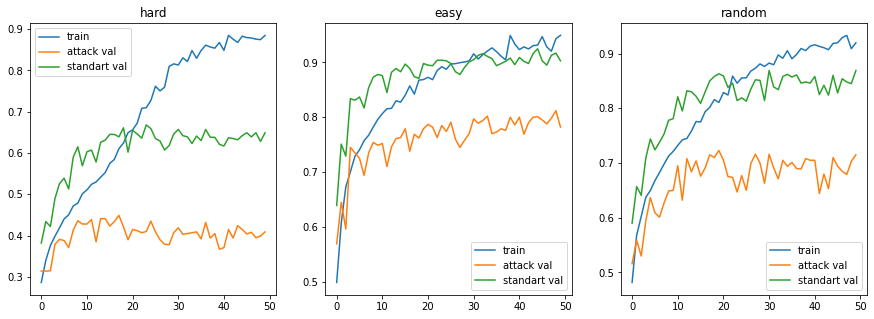

In [45]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for ax,label in zip(axes,labels):
  ax.plot(range(epochs),acc_train_history[label],label='train')
  ax.plot(range(epochs),acc_pgd_val_history[label],label='attack val')
  ax.plot(range(epochs),acc_st_val_history[label],label='standart val')
  ax.legend()
  ax.set_title(label)

Text(0.5, 1.0, 'standart val')

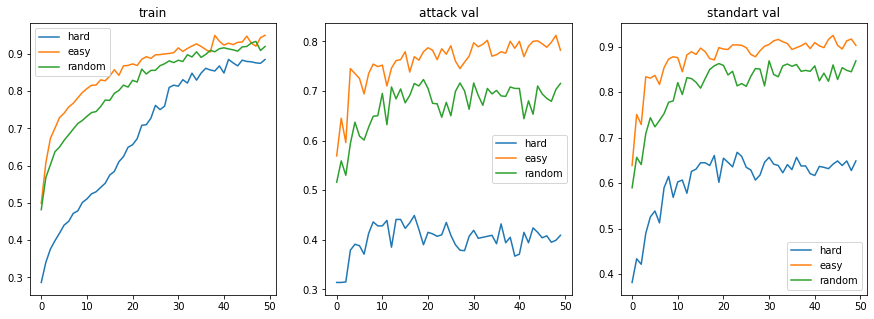

In [46]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for label in labels:
  axes[0].plot(range(epochs),acc_train_history[label],label=label)
  axes[1].plot(range(epochs),acc_pgd_val_history[label],label=label)
  axes[2].plot(range(epochs),acc_st_val_history[label],label=label)

for ax in axes:
  ax.legend()

axes[0].set_title('train')
axes[1].set_title('attack val')
axes[2].set_title('standart val')